# Sentiment analysis across time

Plan
1. Clean data and extract sample - need to decide how large the sample is
2. Extract common phrases from each track in the sample - this is a proxy for chorus.
    * Use gpt-40 mini for this [check pricing]
    * Use claude-4.5
    * perhaps a more powerful reasoning model?
    * Check for if the models pick up the same hooks/common phrases - use cosine similarity and sentence embeddings.
3. Extract sentiment of track over time using the following models:
    * gpt-40-mini
    * bert-trbs
    * Use claude-4.5
    * perhaps a more powerful model (to do)
    * consider whether you can smooth charts to show trend
4. Extract sentiment of common phrases (proxy for hooks/chorus) using the following models:
    * gpt-40-mini
    * bert-trbs (to do)
    * Use claude-4.5
    * perhaps a more powerful model (to do)
    * consider whether you can smooth charts to show trend
5. Write blog and publish on councilsofthefuture.org

Could do
* Evaluate whether the models have successfully picked up lyrics using LLM as judge
    * Could maybe do this by looking at my 50-100 favourite songs, and seeing how well it picks out lyrics?
    * would probabaly need ground truth - leave this for the genre bias where you have ground truth of genre?)


In [1]:
#Import packages
import pandas as pd
import re
import uuid
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import time
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

#Load keys for LLMs
load_dotenv()

#Initialise aysync clients
import asyncio
import re
import pandas as pd
from openai import AsyncOpenAI
from anthropic import AsyncAnthropic
from tqdm.notebook import tqdm

# Initialize async clients
openai_client = AsyncOpenAI(api_key = os.getenv("OPENAI_API_KEY"))
anthropic_client = AsyncAnthropic(api_key = os.getenv("ANTHROPIC_API_KEY"))

#Added to ensure that it uses the apple M1 cores.
#https://github.com/jeffheaton/app_deep_learning/blob/main/install/pytorch-install-aug-2023.ipynb
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()

# Automatically use MPS on Mac if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


# 1. Data Preprocessing

In [2]:
# #Read data
# print("Read lyrics data...")

# file_path = '../data/raw/song_lyrics.csv'

# chunk_size = 100000

# chunks = []

# for chunk in pd.read_csv(file_path, chunksize=chunk_size):

#     chunks.append(chunk)

# # Concatenate all chunks into a single DataFrame if needed
# print("Concact chunks into data frame...")
# song_lyrics_full_df = pd.concat(chunks, ignore_index=True)

# #Data Preprocessing using EDA analysis.

# #Clean text
# def clean_lyrics(text):
    
#     #Remove text between brackets - this contains META information on verse and chorus - maybe do this seperately.
#     text = re.sub(r'\[.*?\]', '', text)
    
#     # Remove newline and tab characters
#     text = re.sub(r'[\n\t]', ' ', text)
    
#     # Remove special characters and digits (optional, depending on use case)
#     text = re.sub(r'[^A-Za-z\s]', '', text)
    
#     # Normalize whitespace
#     text = re.sub(r'\s+', ' ', text).strip()
    
#     # Convert to lowercase
#     text = text.lower()
    
#     return text

# ### Clean Lyrics ###

# #Undertake data cleaning
# print("Prepare data frame for data cleaning...")
# song_lyrics_clean_df = song_lyrics_full_df.copy()

# #Rename tag as genre
# print("update tag as genre")
# song_lyrics_clean_df = song_lyrics_clean_df.rename(columns = {"tag" : "genre"})

# #Add track id
# print("add track_id")
# song_lyrics_clean_df['track_id'] = [str(uuid.uuid4()) for _ in range(len(song_lyrics_clean_df))]

# #Filter data for english lyrics
# print("Filter for English lyrics...")
# song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['language'] == 'en')]

# #Filter data to remove artists containing "Genius"
# print("Filter to remove artists containing the word 'Genius'")
# song_lyrics_clean_df  = song_lyrics_clean_df [~song_lyrics_clean_df ['artist'].str.contains('Genius', case=False, na=False)]

# #Filter for data between 1950 and 2022
# print("Filter for songs released between 1880 and 2022")
# song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['year'] >= 1950) & (song_lyrics_clean_df['year'] <= 2022)]

# #Filter data for misc genre
# print("Remove songs under the misc genre")
# song_lyrics_clean_df = song_lyrics_clean_df[~(song_lyrics_clean_df['genre'] == 'misc')]

# #Filter this population for songs with views more than 95 percentile
# print("Keep songs with in 95th percentile of views")
# percentile_95 = song_lyrics_clean_df['views'].quantile(0.95)
# print(f"The 95th percentile of views is: {percentile_95}")
# song_lyrics_clean_df = song_lyrics_clean_df[(song_lyrics_clean_df['views'] >= percentile_95)]

# #Clean text - there should really be a clean_lyrics column, not overwrite lyrics.
# print(len(song_lyrics_clean_df))
# print("clean song lyrics")
# song_lyrics_clean_df['clean_lyrics'] = song_lyrics_clean_df['lyrics'].apply(clean_lyrics)

# # Drop unecessary columns
# print("drop columns that are not required")
# song_lyrics_clean_df = song_lyrics_clean_df.drop(columns=['id','language_cld3','language_ft'])

# # Column ordering
# song_lyrics_clean_df = song_lyrics_clean_df[['track_id','artist','features','title','year','genre','views','language','lyrics','clean_lyrics']]

# # save to csv
# song_lyrics_clean_df.to_csv("../data/processed/song_lyrics_clean_df.csv",index=False)


In [3]:
#Read clean dataset (if required)
song_lyrics_clean_df = pd.read_csv("../data/processed/song_lyrics_clean_df.csv")

#Generate sample for analysis
#Select 50 songs per year.
song_lyrics_clean_sample_df = song_lyrics_clean_df.copy()
#song_lyrics_clean_sample_df= song_lyrics_clean_sample_df.groupby('year').apply(lambda x: x.sample(n=50, random_state=42) if len(x) > 50 else x)
song_lyrics_clean_sample_df= song_lyrics_clean_sample_df.groupby('year').apply(lambda x: x.sample(n=2, random_state=42) if len(x) > 1 else x)
song_lyrics_clean_sample_df = song_lyrics_clean_sample_df.reset_index(drop=True)

#song_lyrics_clean_sample_df = song_lyrics_clean_sample_df.head(5)

print("Number of samples: ", len(song_lyrics_clean_sample_df))

#Graph of distribution of songs per year

Number of samples:  146


/var/folders/52/f3r19jwn72s9q8h3h8bsc8vh0000gn/T/ipykernel_5074/3889740244.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  song_lyrics_clean_sample_df= song_lyrics_clean_sample_df.groupby('year').apply(lambda x: x.sample(n=2, random_state=42) if len(x) > 1 else x)


# 2. Extract common phrases from lyrics and compare outputs between LLMs

TODO
* May need to turn down the temprateure as a couple of the lyrics show thought process - claude
* Compare common phrases between models - check for degree of agreement/disagreement.
* Use an LLM to evaluate that the lyrics extracted feature in the actual lyrics
* Could do with a dataset where I extract the hook for a song, and see if it turns up as one of the key phrases.
* Maybe do this on a sample of the sample? 

## Using Async

In [4]:
# Cell 2: Prompt function (unchanged)
def phrase_extraction_prompt(lyrics):
    return f"""
You are a helpful music analyst.
From the following song lyrics, extract the top 3 most frequently repeated *phrases*.
A phrase is any sequence of words that appears on a new line.
Ignore case and punctuation. Return only the 3 most frequent phrases.
Respond in the following XML format:
<phrases>
<phrase>...</phrase>
<phrase>...</phrase>
<phrase>...</phrase>
</phrases>
Lyrics:
\"\"\"
{lyrics}
\"\"\"
""".strip()


# Cell 3: Async OpenAI function
async def get_common_phrases_from_lyrics_async(lyrics, model="gpt-4o-mini"):
    """
    Get common lyrics from GPT using an OpenAI model (async version).
    """
    prompt = phrase_extraction_prompt(lyrics)
    response = await openai_client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You analyze song lyrics."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.1
    )
    return response.choices[0].message.content.strip()


# Cell 4: Async Claude function
async def get_common_phrases_from_lyrics_claude_async(lyrics, model="claude-sonnet-4-5-20250929"):
    """
    Get common lyrics from Claude (async version).
    """
    prompt = phrase_extraction_prompt(lyrics)
    response = await anthropic_client.messages.create(
        model=model,
        max_tokens=1000,
        system="You analyze song lyrics.",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1
    )
    return response.content[0].text.strip()

# Cell 5: Process all rows with concurrency control
async def process_all_rows(df, max_concurrent=50):
    """
    Process all rows with both OpenAI and Claude, with concurrency control.
    """
    semaphore = asyncio.Semaphore(max_concurrent)
    
    async def process_row_openai(lyrics):
        async with semaphore:
            try:
                return await get_common_phrases_from_lyrics_async(lyrics)
            except Exception as e:
                print(f"OpenAI error: {e}")
                return None
    
    async def process_row_claude(lyrics):
        async with semaphore:
            try:
                return await get_common_phrases_from_lyrics_claude_async(lyrics)
            except Exception as e:
                print(f"Claude error: {e}")
                return None
    
    # Create tasks for all rows
    openai_tasks = [process_row_openai(lyrics) for lyrics in df['lyrics']]
    claude_tasks = [process_row_claude(lyrics) for lyrics in df['lyrics']]
    
    # Process OpenAI requests - use gather to maintain order
    print("Processing OpenAI requests...")
    openai_results = await asyncio.gather(*openai_tasks)
    print(f"✓ Completed {len(openai_results)} OpenAI requests")
    
    # Process Claude requests - use gather to maintain order
    print("\nProcessing Claude requests...")
    claude_results = await asyncio.gather(*claude_tasks)
    print(f"✓ Completed {len(claude_results)} Claude requests")
    
    return openai_results, claude_results


# Cell 6: Run the async processing
print("Extract top three common phrases...")

# Run async processing (use await directly in Jupyter)
openai_results, claude_results = await process_all_rows(
    song_lyrics_clean_sample_df, 
    max_concurrent=50  # Adjust based on your API limits
)

# Add results to dataframe
song_lyrics_clean_sample_df['common_phrases_gpt_4o-mini'] = openai_results
song_lyrics_clean_sample_df['common_phrases_claude_4_5'] = claude_results

print("\n✓ Complete!")
print(f"OpenAI successful: {sum(1 for r in openai_results if r is not None)}/{len(openai_results)}")
print(f"Claude successful: {sum(1 for r in claude_results if r is not None)}/{len(claude_results)}")

Extract top three common phrases...
Processing OpenAI requests...
✓ Completed 146 OpenAI requests

Processing Claude requests...
Claude error: Error code: 500 - {'type': 'error', 'error': {'type': 'api_error', 'message': 'Overloaded'}, 'request_id': None}
Claude error: Error code: 500 - {'type': 'error', 'error': {'type': 'api_error', 'message': 'Overloaded'}, 'request_id': None}
✓ Completed 146 Claude requests

✓ Complete!
OpenAI successful: 146/146
Claude successful: 144/146


## Compare lyric outputs using cosine similarity

TBC


In [5]:
def extract_phrases_from_xml(xml_string):
    """
    Extracts phrases from XML format and returns them as a list.
    """
    try:
        # Handle None or empty values
        if pd.isna(xml_string) or xml_string == '':
            return []
        
        # Parse the XML string
        root = ET.fromstring(xml_string)
        
        # Extract all phrase texts
        phrases = [phrase.text for phrase in root.findall('phrase') if phrase.text]
        
        return phrases
    except Exception as e:
        print(f"Error parsing XML: {e}")
        return []

# Apply to your dataframe columns
song_lyrics_clean_sample_df['common_phrases_claude_4_5_list'] = song_lyrics_clean_sample_df['common_phrases_claude_4_5'].apply(extract_phrases_from_xml)

Error parsing XML: not well-formed (invalid token): line 1, column 1
Error parsing XML: not well-formed (invalid token): line 1, column 1
Error parsing XML: not well-formed (invalid token): line 1, column 1
Error parsing XML: syntax error: line 1, column 0
Error parsing XML: syntax error: line 1, column 0
Error parsing XML: not well-formed (invalid token): line 1, column 1
Error parsing XML: not well-formed (invalid token): line 1, column 1
Error parsing XML: syntax error: line 1, column 0
Error parsing XML: syntax error: line 1, column 0
Error parsing XML: not well-formed (invalid token): line 1, column 1
Error parsing XML: syntax error: line 1, column 0
Error parsing XML: syntax error: line 1, column 0
Error parsing XML: not well-formed (invalid token): line 1, column 1
Error parsing XML: syntax error: line 1, column 0
Error parsing XML: not well-formed (invalid token): line 1, column 1
Error parsing XML: syntax error: line 1, column 0
Error parsing XML: syntax error: line 1, column 

In [6]:
def extract_phrases_from_xml_md(xml_string):
    """
    Extracts phrases from XML format and returns them as a list.
    Handles markdown code blocks (```xml ... ```)
    """
    try:
        # Handle None or empty values
        if pd.isna(xml_string) or xml_string == '':
            return []
        
        # Remove markdown code block markers
        xml_string = xml_string.strip()
        if xml_string.startswith('```xml'):
            xml_string = xml_string[6:]  # Remove ```xml
        if xml_string.startswith('```'):
            xml_string = xml_string[3:]  # Remove ``` (in case it's just ```)
        if xml_string.endswith('```'):
            xml_string = xml_string[:-3]  # Remove closing ```
        
        xml_string = xml_string.strip()
        
        # Parse the XML string
        root = ET.fromstring(xml_string)
        
        # Extract all phrase texts
        phrases = [phrase.text for phrase in root.findall('phrase') if phrase.text]
        
        return phrases
    except Exception as e:
        print(f"Error parsing XML: {e}")
        print(f"Problematic string: {xml_string[:100]}")  # Print first 100 chars for debugging
        return []

# Apply to your column
song_lyrics_clean_sample_df['common_phrases_gpt_4o-mini_list'] = song_lyrics_clean_sample_df['common_phrases_gpt_4o-mini'].apply(extract_phrases_from_xml_md)

In [7]:
#Run cosine similairty 
model = SentenceTransformer('all-MiniLM-L6-v2')

cosine_similarity_df = song_lyrics_clean_sample_df[['track_id','common_phrases_gpt_4o-mini_list','common_phrases_claude_4_5_list']]

# Remove rows where either column has an empty list
cosine_similarity_df  = cosine_similarity_df [(cosine_similarity_df ['common_phrases_gpt_4o-mini_list'].str.len() > 0) & 
                                              (cosine_similarity_df ['common_phrases_claude_4_5_list'].str.len() > 0)]


# Join phrases with spaces
cosine_similarity_df ['common_phrases_gpt_4o-mini_combined'] = cosine_similarity_df ['common_phrases_gpt_4o-mini_list'].apply(lambda x: ' '.join(x))
cosine_similarity_df ['common_phrases_claude_4_5_combined'] = cosine_similarity_df ['common_phrases_claude_4_5_list'].apply(lambda x: ' '.join(x))

# Calculate embeddings
cosine_similarity_df ['common_phrases_gpt_4o-mini_embeddings'] = cosine_similarity_df ['common_phrases_gpt_4o-mini_combined'].apply(lambda x: model.encode(x))
cosine_similarity_df ['common_phrases_claude_4_5_embeddings'] = cosine_similarity_df ['common_phrases_claude_4_5_combined'].apply(lambda x: model.encode(x))

# Calculate similarity as before
def calculate_row_similarity(row):
    emb1 = row['common_phrases_gpt_4o-mini_embeddings'].reshape(1, -1)
    emb2 = row['common_phrases_claude_4_5_embeddings'].reshape(1, -1)
    return cosine_similarity(emb1, emb2)[0][0]

cosine_similarity_df['similarity_score'] = cosine_similarity_df.apply(calculate_row_similarity, axis=1)

/opt/miniconda3/envs/lyrical_sentiment/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


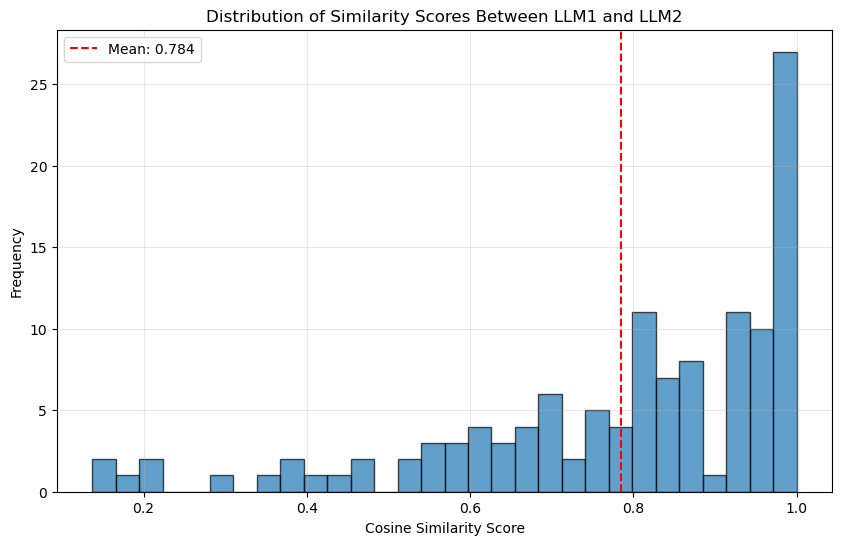

In [8]:
#Visualise results with hisotgram
plt.figure(figsize=(10, 6))
plt.hist(cosine_similarity_df['similarity_score'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores Between LLM1 and LLM2')
plt.axvline(cosine_similarity_df['similarity_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {cosine_similarity_df["similarity_score"].mean():.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

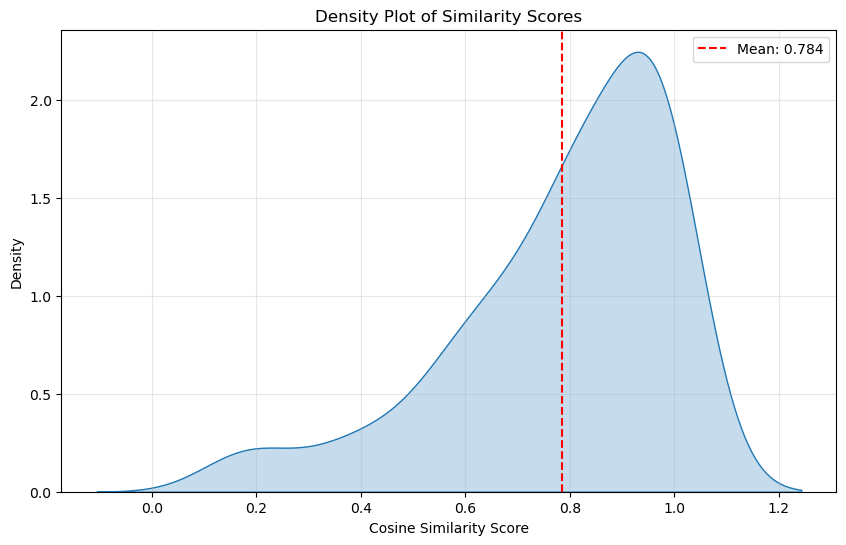

In [9]:
#Visualise results with KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=cosine_similarity_df['similarity_score'], fill=True)
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Density')
plt.title('Density Plot of Similarity Scores')
plt.axvline(cosine_similarity_df['similarity_score'].mean(), color='red', linestyle='--', 
            label=f'Mean: {cosine_similarity_df["similarity_score"].mean():.3f}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 3. Sentiment over time - whole song

## BERT - TRBS Model

In [ ]:
def load_model(device,model_name):

    MODEL = model_name 
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
    labels = ['negative', 'neutral', 'positive']

    return tokenizer, model, labels

#Function to classify lyrics
def classify_sentiment(text,labels,model,tokenizer,device):
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].cpu().numpy()  # move to CPU for NumPy
    return dict(zip(labels, map(float, probs)))

#Function for chunking text in case lyrics are longer than 512 tokens
def chunk_text(text, tokenizer, max_tokens=512):
    tokens = tokenizer.tokenize(text)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        token_chunk = tokens[i:i + max_tokens]
        text_chunk = tokenizer.convert_tokens_to_string(token_chunk)
        chunks.append(text_chunk)
    return chunks


def sentiment_over_chunks(lyrics, tokenizer,labels, model, device):
    
    chunks = chunk_text(lyrics, tokenizer, max_tokens=512)
    
    all_scores = [classify_sentiment(chunk,labels,model,tokenizer,device) for chunk in chunks]
    
    # Aggregate: average scores per label
    avg_scores = {label: np.mean([score[label] for score in all_scores]) for label in labels}
    
    # Add label with highest average score
    top_label = max(avg_scores, key=avg_scores.get)
    
    return {
        'label': top_label,
        'scores': avg_scores
    }


def collapse_to_binary(label_scores):
    if label_scores['positive'] > label_scores['negative']:
        return 'positive'
    else:
        return 'negative'
    
# Load model and tokenizer once
print("Load BERT-TRBS model...")
tokenizer, model, labels = load_model(device = device,
                                      model_name = "cardiffnlp/twitter-roberta-base-sentiment")

#Apply sentiment over chunks of "clean lyrics"
print("Apply senitment over chunks...")
song_lyrics_clean_sample_df['sentiment_trbs'] = song_lyrics_clean_sample_df.apply(lambda row: sentiment_over_chunks(lyrics = row['clean_lyrics'],
                                                                                                               tokenizer=tokenizer,
                                                                                                               labels = labels, 
                                                                                                               model = model, 
                                                                                                               device= device), 
                                                                                                               axis=1)

#Extract sentiment into different columns
print("Extract sentiment labels into new columns...")
song_lyrics_clean_sample_df['sentiment_trbs_label'] = song_lyrics_clean_sample_df['sentiment_trbs'].apply(lambda x: x['label'])
song_lyrics_clean_sample_df['sentiment_trbs_positive'] = song_lyrics_clean_sample_df['sentiment_trbs'].apply(lambda x: x['scores']['positive'])
song_lyrics_clean_sample_df['sentiment_trbs_negative'] = song_lyrics_clean_sample_df['sentiment_trbs'].apply(lambda x: x['scores']['negative'])
song_lyrics_clean_sample_df['sentiment_trbs_neutral'] = song_lyrics_clean_sample_df['sentiment_trbs'].apply(lambda x: x['scores']['neutral'])


Load BERT-TRBS model...


/opt/miniconda3/envs/lyrical_sentiment/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Apply senitment over chunks...


In [ ]:
#generate graph of sentiment over time
trbs_positive_sentiment_per_year_plt = song_lyrics_clean_sample_df.groupby('year')['sentiment_trbs_positive'].mean().plot(title="Positive sentiment of songs TBC (n=" + str(len(song_lyrics_clean_sample_df)) +",bert-trbs)",
                                                                                                                    ylabel="Average positive sentiment")

In [ ]:
trbs_negative_sentiment_per_year_plt = song_lyrics_clean_sample_df.groupby('year')['sentiment_trbs_negative'].mean().plot(title="Negative sentiment of songs TBC (n=" + str(len(song_lyrics_clean_sample_df)) +",bert-trbs)",
                                                                                                                     ylabel="Average negative sentiment")

In [ ]:
trbs_neutral_sentiment_per_year_plt = song_lyrics_clean_sample_df.groupby('year')['sentiment_trbs_neutral'].mean().plot(title="Neutral sentiment of songs TBC (n=" + str(len(song_lyrics_clean_sample_df)) +",bert-trbs)",
                                                                                                                     ylabel="Average neutral sentiment")

## Using an LLM + Async

In [ ]:
# Cell 2: Prompt function (unchanged)
def lyrics_sentiment_score_prompt(lyrics):
    return f"""
                <role>
                You are an expert music critic.
                </role>
                <task>
                Rate the emotional sentiment of the following song lyrics on a scale from -1 (very negative) to 1 (very positive), where 0 is emotionally neutral.
                </task>
                <instruction>
                Only return a single number. No explanation.
                </instruction>
                <lyrics>
\"\"\"
{lyrics}
\"\"\"
                </lyrics>
                """


# Cell 3: Async OpenAI function
async def get_lyrics_sentiment_score_async(lyrics, model="gpt-4o-mini", max_retries=3):
    """
    Get sentiment score between -1 and 1 from GPT using API (async version).
    """
    prompt = lyrics_sentiment_score_prompt(lyrics=lyrics)
    
    for attempt in range(max_retries):
        try:
            response = await openai_client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt.strip()},
                ],
                temperature=0.0,
            )
            output = response.choices[0].message.content.strip()
            
            # Robust float parsing
            match = re.search(r"-?\d+(?:\.\d+)?", output)
            if match:
                return float(match.group())
            else:
                print(f"[Warning] Couldn't parse score: {output}")
                return None
                
        except Exception as e:
            print(f"[Retry {attempt+1}] Error: {e}")
            if attempt < max_retries - 1:
                await asyncio.sleep(2)  # Use asyncio.sleep instead of time.sleep
    
    return None


# Cell 4: Async Claude function
async def get_lyrics_sentiment_score_claude_async(lyrics, model="claude-sonnet-4-5-20250929", max_retries=3):
    """
    Get sentiment score between -1 and 1 from Claude using API (async version).
    """
    prompt = lyrics_sentiment_score_prompt(lyrics=lyrics)
    
    for attempt in range(max_retries):
        try:
            response = await anthropic_client.messages.create(
                model=model,
                max_tokens=1000,
                system="You are an expert music critic.",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0
            )
            output = response.content[0].text.strip()
            
            # Robust float parsing
            match = re.search(r"-?\d+(?:\.\d+)?", output)
            if match:
                return float(match.group())
            else:
                print(f"[Warning] Couldn't parse score: {output}")
                return None
                
        except Exception as e:
            print(f"[Retry {attempt+1}] Error: {e}")
            if attempt < max_retries - 1:
                await asyncio.sleep(2)  # Use asyncio.sleep instead of time.sleep
    
    return None


# Cell 5: Process all rows with rate limiting
async def process_sentiment_scores(df, column='clean_lyrics', max_concurrent=50):
    """
    Process all rows for both OpenAI and Claude with concurrency control.
    """
    semaphore = asyncio.Semaphore(max_concurrent)
    
    async def process_openai(lyrics):
        async with semaphore:
            return await get_lyrics_sentiment_score_async(lyrics)
    
    async def process_claude(lyrics):
        async with semaphore:
            return await get_lyrics_sentiment_score_claude_async(lyrics)
    
    # Create tasks for all rows
    print("Processing OpenAI sentiment scores...")
    openai_tasks = [process_openai(lyrics) for lyrics in df[column]]
    
    # Use asyncio.gather to maintain order (preserves row order)
    # Wrap with tqdm for progress tracking
    openai_results = []
    with tqdm(total=len(openai_tasks), desc="OpenAI") as pbar:
        for coro in asyncio.as_completed(openai_tasks):
            await coro
            pbar.update(1)
        # Now gather them in order
        openai_results = await asyncio.gather(*[process_openai(lyrics) for lyrics in df[column]])
    
    # Process Claude requests
    print("\nProcessing Claude sentiment scores...")
    claude_tasks = [process_claude(lyrics) for lyrics in df[column]]
    
    # Use asyncio.gather to maintain order (preserves row order)
    claude_results = []
    with tqdm(total=len(claude_tasks), desc="Claude") as pbar:
        for coro in asyncio.as_completed(claude_tasks):
            await coro
            pbar.update(1)
        # Now gather them in order
        claude_results = await asyncio.gather(*[process_claude(lyrics) for lyrics in df[column]])
    
    return openai_results, claude_results


# Cell 6: Run the processing
print("Apply sentiment scoring...")

# Run async processing (use await directly in Jupyter)
openai_scores, claude_scores = await process_sentiment_scores(
    song_lyrics_clean_sample_df,
    column='clean_lyrics',
    max_concurrent=50  # Adjust based on your API limits
)

# Add results to dataframe
song_lyrics_clean_sample_df['sentiment_score_gpt_4o_mini'] = openai_scores
song_lyrics_clean_sample_df['sentiment_score_claude_4_5'] = claude_scores

# Make sure sentiment is numeric
song_lyrics_clean_sample_df['sentiment_score_gpt_4o_mini'] = pd.to_numeric(
    song_lyrics_clean_sample_df['sentiment_score_gpt_4o_mini'], 
    errors='coerce'
)
song_lyrics_clean_sample_df['sentiment_score_claude_4_5'] = pd.to_numeric(
    song_lyrics_clean_sample_df['sentiment_score_claude_4_5'], 
    errors='coerce'
)

print("\n✓ Complete!")
print(f"OpenAI - Successful: {song_lyrics_clean_sample_df['sentiment_score_gpt_4o_mini'].notna().sum()}")
print(f"OpenAI - Failed: {song_lyrics_clean_sample_df['sentiment_score_gpt_4o_mini'].isna().sum()}")
print(f"Claude - Successful: {song_lyrics_clean_sample_df['sentiment_score_claude_4_5'].notna().sum()}")
print(f"Claude - Failed: {song_lyrics_clean_sample_df['sentiment_score_claude_4_5'].isna().sum()}")

In [ ]:
# Group by year
yearly_sentiment_gpt_plt = song_lyrics_clean_sample_df.groupby('year')['sentiment_score_gpt_4o_mini'].mean().plot(title="Average sentiment of song lyrics TBC (n=" + str(len(song_lyrics_clean_sample_df)) +",gpt-4o-mini)",
                                                                                                          ylabel="Sentiment")

In [ ]:
# Group by year
yearly_sentiment_claude_plt = song_lyrics_clean_sample_df.groupby('year')['sentiment_score_claude_4_5'].mean().plot(title="Average sentiment of song lyrics TBC (n=" + str(len(song_lyrics_clean_sample_df)) +",claude)",
                                                                                                                ylabel="Sentiment")

# 4. Sentiment over time - common phrases

In [ ]:
# Prompt function (unchanged)
def phrase_sentiment_prompt(xml_phrases):
    return f"""
            You are an expert sentiment analyst.
            Given a list of phrases from music lyrics in XML format, return a emotional sentiment score for each phrase.
            Each score must be a number between -1 and 1, where:
            -1 = very negative, 0 = emotionally neutral, 1 = very positive.
            Respond in the following XML format:
            <phrase_sentiments>
            <phrase text="...">[sentiment_score]</phrase>
            ...
            </phrase_sentiments>
            Here is the list of phrases:
{xml_phrases}
            """.strip()


# Parsing function (unchanged)
def parse_phrase_sentiment_scores(xml_text):
    try:
        return [(phrase, float(score)) for phrase, score in re.findall(r'<phrase text="(.*?)">(.*?)</phrase>', xml_text)]
    except:
        return []


# Async OpenAI function
async def get_phrase_sentiment_scores_async(xml_phrases, model="gpt-4o-mini"):
    """
    Get sentiment of common lyrics from GPT using an OpenAI model (async version).
    """
    prompt = phrase_sentiment_prompt(xml_phrases)
    response = await openai_client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You analyze sentiment of music lyrics with numeric scores."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    return response.choices[0].message.content.strip()


# Async Claude function
async def get_phrase_sentiment_scores_claude_async(xml_phrases, model="claude-sonnet-4-5-20250929"):
    """
    Get sentiment of common lyrics from Claude (async version).
    """
    prompt = phrase_sentiment_prompt(xml_phrases)
    response = await anthropic_client.messages.create(
        model=model,
        max_tokens=1000,
        system="You analyze sentiment of music lyrics with numeric scores",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.0
    )
    return response.content[0].text.strip()


# Process all rows with concurrency control
async def process_phrase_sentiments(df, max_concurrent=50):
    """
    Process all rows for phrase sentiment analysis with both OpenAI and Claude.
    """
    semaphore = asyncio.Semaphore(max_concurrent)
    
    async def process_openai(xml_phrases):
        async with semaphore:
            try:
                return await get_phrase_sentiment_scores_async(xml_phrases)
            except Exception as e:
                print(f"OpenAI error: {e}")
                return None
    
    async def process_claude(xml_phrases):
        async with semaphore:
            try:
                return await get_phrase_sentiment_scores_claude_async(xml_phrases)
            except Exception as e:
                print(f"Claude error: {e}")
                return None
    
    # Create tasks for all rows
    print("Processing OpenAI phrase sentiment requests...")
    openai_tasks = [process_openai(phrases) for phrases in df['common_phrases_gpt_4o-mini']]
    openai_results = await asyncio.gather(*openai_tasks)
    print(f"✓ Completed {len(openai_results)} OpenAI requests")
    
    print("\nProcessing Claude phrase sentiment requests...")
    claude_tasks = [process_claude(phrases) for phrases in df['common_phrases_claude_4_5']]
    claude_results = await asyncio.gather(*claude_tasks)
    print(f"✓ Completed {len(claude_results)} Claude requests")
    
    return openai_results, claude_results


# Run the async processing
print("Getting phrase sentiment scores...")

# Run async processing (use await directly in Jupyter)
openai_sentiment_results, claude_sentiment_results = await process_phrase_sentiments(
    song_lyrics_clean_sample_df,
    max_concurrent=50  # Adjust based on your API limits
)

# Add results to dataframe
song_lyrics_clean_sample_df['common_phrases_sentiment_gpt_4o-mini'] = openai_sentiment_results
song_lyrics_clean_sample_df['common_phrases_sentiment_claude_4_5'] = claude_sentiment_results

print("\nParse sentiment from xml......")
song_lyrics_clean_sample_df['common_phrases_sentiment_gpt_4o-mini'] = song_lyrics_clean_sample_df['common_phrases_sentiment_gpt_4o-mini'].apply(parse_phrase_sentiment_scores)
song_lyrics_clean_sample_df['common_phrases_sentiment_claude_4_5'] = song_lyrics_clean_sample_df['common_phrases_sentiment_claude_4_5'].apply(parse_phrase_sentiment_scores)

print("Calculate average sentiment...")
song_lyrics_clean_sample_df['common_phrases_average_sentiment_gpt_4o-mini'] = song_lyrics_clean_sample_df['common_phrases_sentiment_gpt_4o-mini'].apply(
    lambda lst: round(sum(score for _, score in lst) / len(lst), 3) if lst else None
)
song_lyrics_clean_sample_df['common_phrases_average_sentiment_claude_4_5'] = song_lyrics_clean_sample_df['common_phrases_sentiment_claude_4_5'].apply(
    lambda lst: round(sum(score for _, score in lst) / len(lst), 3) if lst else None
)

print("\n✓ Complete!")
print(f"OpenAI successful: {sum(1 for r in openai_sentiment_results if r is not None)}/{len(openai_sentiment_results)}")
print(f"Claude successful: {sum(1 for r in claude_sentiment_results if r is not None)}/{len(claude_sentiment_results)}")

In [ ]:
#generate graph of sentiment over time
print("Generate sentiment over time...")
common_phrases_sentiment_per_year_gpt_plt = song_lyrics_clean_sample_df.groupby('year')['common_phrases_average_sentiment_gpt_4o-mini'].mean().plot(title="TBC common phrases (n=" + str(len(song_lyrics_clean_sample_df)) +",gpt-4o-mini)",
                                                                                                                                   ylabel="sentiment")

In [ ]:
#generate graph of sentiment over time
print("Generate sentiment over time...")
common_phrases_sentiment_per_year_claude_plt = song_lyrics_clean_sample_df.groupby('year')['common_phrases_average_sentiment_claude_4_5'].mean().plot(title="TBC common phrases (n=" + str(len(song_lyrics_clean_sample_df)) +",claude-4-5)",
                                                                                                                                              ylabel="sentiment")